In [1]:
import caffe
import lmdb
import glob
import skimage
from skimage import io
import numpy
from skimage.transform import resize
import numpy as np
from caffe import layers as L
from caffe import params as P
from pylab import *
import pandas as pd
%matplotlib inline

In [2]:
# from caffe import layers as L
# from caffe import params as P

def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.ip1 = L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    
#     n.conv3 = L.Convolution(n.relu1, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
#     n.pool3 = L.Pooling(n.conv3, kernel_size=2, stride=2, pool=P.Pooling.MAX)
#     n.conv4 = L.Convolution(n.pool3, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
#     n.pool4 = L.Pooling(n.conv4, kernel_size=2, stride=2, pool=P.Pooling.MAX)
#     n.ip2 = L.InnerProduct(n.pool4, num_output=500, weight_filler=dict(type='xavier'))
#     n.relu2 = L.ReLU(n.ip2, in_place=True)
    
    n.ip2 = L.InnerProduct(n.relu1, num_output=2, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.ip2, n.label)
    n.prob = L.Softmax(n.ip2)
    return n.to_proto()
    
with open('/home/ubuntu/caffe/yelp/yelp_train.prototxt', 'w') as f:
    f.write(str(lenet('/home/ubuntu/caffe/yelp/train_1_lmdb_80', 64)))
    
with open('/home/ubuntu/caffe/yelp/yelp_test.prototxt', 'w') as f:
    f.write(str(lenet('/home/ubuntu/caffe/yelp/test_1_lmdb_80', 100)))
    

In [2]:
from caffe import layers as L, params as P, to_proto
from caffe.proto import caffe_pb2

# helper function for common structures

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                                num_output=nout, pad=pad, group=group)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout):
    fc = L.InnerProduct(bottom, num_output=nout)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(lmdb, batch_size=128, include_acc=False):
    data, label = L.Data(source=lmdb, backend=P.Data.LMDB, batch_size=batch_size, ntop=2,
        transform_param=dict(crop_size=227, mean_value=[104, 117, 123], mirror=True))

    # the net itself
    conv1, relu1 = conv_relu(data, 11, 96, stride=4)
    pool1 = max_pool(relu1, 3, stride=2)
    norm1 = L.LRN(pool1, local_size=5, alpha=1e-4, beta=0.75)
    conv2, relu2 = conv_relu(norm1, 5, 256, pad=2, group=2)
    pool2 = max_pool(relu2, 3, stride=2)
    norm2 = L.LRN(pool2, local_size=5, alpha=1e-4, beta=0.75)
    conv3, relu3 = conv_relu(norm2, 3, 384, pad=1)
    conv4, relu4 = conv_relu(relu3, 3, 384, pad=1, group=2)
    conv5, relu5 = conv_relu(relu4, 3, 256, pad=1, group=2)
    pool5 = max_pool(relu5, 3, stride=2)
    fc6, relu6 = fc_relu(pool5, 4096)
    drop6 = L.Dropout(relu6, in_place=True)
    fc7, relu7 = fc_relu(drop6, 4096)
    drop7 = L.Dropout(relu7, in_place=True)
    fc8 = L.InnerProduct(drop7, num_output=2)
    loss = L.SoftmaxWithLoss(fc8, label)

    if include_acc:
        acc = L.Accuracy(fc8, label)
        return to_proto(loss, acc)
    else:
        return to_proto(loss)

with open('/home/ubuntu/caffe/yelp/yelp_train.prototxt', 'w') as f:
    f.write(str(caffenet('/home/ubuntu/caffe/yelp/train_0_up2_lmdb_250size')))

with open('/home/ubuntu/caffe/yelp/yelp_test.prototxt', 'w') as f:
    f.write(str(caffenet('/home/ubuntu/caffe/yelp/test_0_lmdb_250size')))


In [3]:
caffe.set_device(0)
caffe.set_mode_gpu()

In [4]:
solver = caffe.SGDSolver('/home/ubuntu/caffe/yelp/yelp_solver.prototxt')

In [5]:
%%time
# training process
niter = 900
for it in range(niter):
    solver.step(1)

CPU times: user 1min 32s, sys: 46.3 s, total: 2min 19s
Wall time: 1min 50s


In [6]:
%%time
# testing process
correct = 0
correct_1 = 0
classify_1 = 0
num_1 = 0
prob_result = np.empty([1])
for test_it in range(151):
    if test_it % 50 == 0:
        print 'Iteration', test_it, 'testing...'
    test_out = solver.test_nets[0].forward()
    prob_result = np.concatenate((prob_result, test_out['prob'][:,1]), axis=0)
    correct += sum(test_out['prob'].argmax(1)
                   == solver.test_nets[0].blobs['label'].data)
    correct_1 += sum(np.logical_and(test_out['prob'].argmax(1)== solver.test_nets[0].blobs['label'].data, 
                     solver.test_nets[0].blobs['label'].data == np.ones(100)))
    classify_1 += sum(test_out['prob'].argmax(1) == np.ones(100))
    num_1 += sum(solver.test_nets[0].blobs['label'].data == np.ones(100, dtype=np.int))

test_acc = correct / 15100.0

Iteration 0 testing...
Iteration 50 testing...
Iteration 100 testing...
Iteration 150 testing...
CPU times: user 3.41 s, sys: 1.52 s, total: 4.93 s
Wall time: 3.54 s


In [7]:
# print prob_result[:20]
print test_out['prob'][:10]

[[ 0.33887598  0.66112399]
 [ 0.27969676  0.72030324]
 [ 0.42320883  0.57679117]
 [ 0.19849065  0.80150932]
 [ 0.46975327  0.53024679]
 [ 0.40132448  0.59867555]
 [ 0.46057993  0.53942007]
 [ 0.48974314  0.51025689]
 [ 0.43329003  0.56670994]
 [ 0.18507372  0.81492627]]


In [8]:
print "correct_1: " + str(correct_1)
print "classify_1: " + str(classify_1)
print "num_1: " + str(num_1)

correct_1: 11514
classify_1: 14323
num_1: 11947


In [9]:
# evaluation
recall = float(correct_1)/num_1
precision = float(correct_1)/classify_1
f1_score = 2*precision*recall/(precision + recall)
print "recall " + str(recall)
print "precision " + str(precision)
print "f1_score " +  str(f1_score)

recall 0.963756591613
precision 0.803881868324
f1_score 0.876589265322


In [10]:
df = pd.read_csv('/home/ubuntu/caffe/yelp/pic/pic_label_subbybus_test.csv', sep=',')
df_sub = df.iloc[:len(prob_result),[0,1,3]]
df_prob = pd.DataFrame({'prob':prob_result})
frames = [df_sub, df_prob]
df_result = pd.concat(frames, axis=1)
print df_result.ix[:5,]

   photo_id  business_id  label_1           prob
0        80         1114        1  6.923340e-310
1        95         3065        1   5.129827e-01
2       130         2687        1   7.947147e-01
3       143         3979        1   5.844797e-01
4       296         1114        1   7.914786e-01
5       337         1160        1   5.463188e-01


In [14]:
# write the result into file
df_result.to_csv('/home/ubuntu/caffe/yelp/prob_result/prob_result7_up3_rot.txt')

NameError: name 'train_loss' is not defined

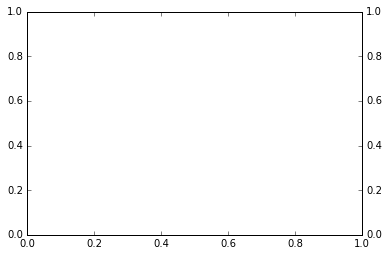

In [22]:
# Accuracy plot
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))